In [43]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.multioutput import MultiOutputRegressor
import numpy as np
import glob
from tqdm.notebook import tqdm
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import json

In [2]:
data_path = 'data2'

In [3]:
ssubm_df = pd.read_csv(os.path.join(data_path, 'input', 'sample_submission.csv'))
ssubm_df = ssubm_df['site_path_timestamp'].apply(lambda x: pd.Series(x.split('_')))
ssubm_df.columns = ['site', 'path', 'timestamp']

In [4]:
site_train_paths = glob.glob(os.path.join(data_path, 'output', 'features', 'train', '*'))

feauter_dfs = list()
for site_train_path in tqdm(site_train_paths):
    feauter_dfs.append(pd.read_csv(site_train_path))

  0%|          | 0/24 [00:00<?, ?it/s]

In [5]:
def create_train_floor_df(feauter_df):
    df = feauter_df.copy()
    Y_np = df['floor'].to_numpy()

    df.drop(['x', 'y', 'floor', 'path', 'sys_ts'], axis=1, inplace=True)
    X_np = df.to_numpy()
    
    return X_np, Y_np

In [6]:
def create_train_position_df(feauter_df):
    df = feauter_df.copy()
    Y_np = df[['x', 'y']].to_numpy()

    df.drop(['x', 'y', 'floor', 'path', 'sys_ts'], axis=1, inplace=True)
    X_np = df.to_numpy()
    
    return X_np, Y_np

In [7]:
floor_models = dict()

for i in tqdm(range(len(site_train_paths))):
    site = site_train_paths[i].split('/')[-1][:-4]
    
    X_np, Y_np = create_train_floor_df(feauter_dfs[i])
    
    floor_model = RandomForestClassifier(n_estimators=20)
    floor_model.fit(X_np, Y_np)
    
    floor_models[site] = floor_model

  0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
for index in tqdm(floor_models):
    model = floor_models[index]
    pickle.dump(model, open(os.path.join(data_path, 'models', 'floor', index+'.sav'), 'wb'))

In [9]:
position_models = dict()

for i in tqdm(range(len(site_train_paths))):
    site = site_train_paths[i].split('/')[-1][:-4]
    
    X_np, Y_np = create_train_position_df(feauter_dfs[i])
    
    position_model = MultiOutputRegressor(ExtraTreesRegressor(n_estimators=40, n_jobs=-1))
    position_model.fit(X_np, Y_np)
                                          
    pickle.dump(position_model, open(os.path.join(data_path, 'models', 'position4', site+'.sav'), 'wb'))
    
    position_models[site] = position_model
    #break

  0%|          | 0/24 [00:00<?, ?it/s]

In [12]:
site_test_paths = glob.glob(os.path.join(data_path, 'output', 'features', 'test', '*'))

test_feauter_dfs = dict()
for site_test_path in tqdm(site_test_paths):
    site = site_test_path.split('/')[-1][:-4]
    test_feauter_dfs[site] = pd.read_csv(site_test_path)

  0%|          | 0/24 [00:00<?, ?it/s]

In [7]:
floor_models = dict()
floor_model_paths = glob.glob(os.path.join(data_path, 'models', 'floor', '*'))

for floor_model_path in tqdm(floor_model_paths):
    site = floor_model_path.split('/')[-1][:-4]
    floor_models[site] = pickle.load(open(floor_model_path, 'rb'))

  0%|          | 0/24 [00:00<?, ?it/s]

In [12]:
position_models = dict()
position_model_paths = glob.glob(os.path.join(data_path, 'models', 'position2', '*'))

for floor_model_path in floor_model_paths:
    site = floor_model_path.split('/')[-1][:-4]
    position_models[site] = dict()

for position_model_path in tqdm(position_model_paths):
    site = position_model_path.split('/')[-1][:-4].split('_')[0]
    floor = int(position_model_path.split('/')[-1][:-4].split('_')[1])
    position_models[site][floor] = pickle.load(open(position_model_path, 'rb'))

  0%|          | 0/139 [00:00<?, ?it/s]

In [23]:
for site in position_models:
    for floor in position_models[site]:
        position_models[site][floor].estimator.base_estimator.n_jobs = 1

In [24]:
position_models['5d2709bb03f801723c32852c'][0].estimator.base_estimator

ExtraTreesRegressor(max_features='sqrt', n_estimators=20, n_jobs=1)

In [13]:
for index, row in tqdm(ssubm_df.iterrows(), total=ssubm_df.shape[0]):
    test_site_feauter_df = test_feauter_dfs[row.site]
    test_path_feauter_df = test_site_feauter_df[test_site_feauter_df.path == row.path]
    #a teljes pathon a szint becslés
    
    dists = list()
    for i, row_feat in test_path_feauter_df.iterrows():
        dist = abs(int(row_feat.sys_ts) - int(row.timestamp))
        dists.append(dist)
    nearests = test_path_feauter_df.iloc[np.argpartition(dists, 2)[:2]]
    #előtte utána nézni
    
    X_np = nearests.to_numpy()[:,:-2]
    
    floor_model = floor_models[row.site]
    floor_pred = floor_model.predict(X_np)[0]
    ssubm_df.loc[index, ['floor']] = floor_pred
    
    position_model = position_models[row.site]
    position_pred = position_model.predict(X_np)
    
    ssubm_df.loc[index, ['x']] = np.mean(position_pred[:,:1])
    ssubm_df.loc[index, ['y']] = np.mean(position_pred[:,1:])

    #break
    

  0%|          | 0/10133 [00:00<?, ?it/s]

In [14]:
ssubm_df['site_path_timestamp'] = ssubm_df['site'] + '_' + ssubm_df['path'] + '_' + ssubm_df['timestamp'] 
ssubm_df.drop(['site', 'path', 'timestamp'], axis=1, inplace=True)

cols = ssubm_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
ssubm_df = ssubm_df[cols]

In [54]:
ssubm_df

,floor,x,y,site,path,timestamp
0,0.0,93.146418,93.638358,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000000009
1,0.0,89.424375,105.238135,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000009017
2,0.0,90.579999,102.992954,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000015326
3,0.0,91.159587,103.638104,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000018763
4,0.0,94.169042,105.080069,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000022328
...,...,...,...,...,...,...
10128,5.0,215.962178,95.476285,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,0000000082589
10129,5.0,211.508142,95.395469,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,0000000085758
10130,5.0,208.956712,106.445820,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,0000000090895
10131,5.0,206.305489,110.037852,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,0000000096899


In [17]:
ssubm_df.to_csv(os.path.join(data_path, 'output', 'submission_6.csv'), index=False)

In [53]:
paths = list()
for gid, g in ssubm_df.groupby(['path']):
    paths.append(g)

In [1]:
int(g['floor'].iloc[0])

NameError: name 'g' is not defined

In [50]:
def visualize_path(path_df):
    site = path_df['site'].iloc[0]
    floor = str(path_df['floor'].iloc[0])[:-2]
    
    base_path = os.path.join(data_path, 'input', 'metadata', site, 'F2')
    
    img = mpimg.imread(os.path.join(base_path,'floor_image.png'))
    
    with open(os.path.join(base_path,'floor_info.json')) as f:
        content = f.read()
        floor_info = json.loads(content)
    height = float(floor_info['map_info']['height'])
    width = float(floor_info['map_info']['width'])
    
    fig = plt.figure(figsize=(15, 12))
    ax = plt.subplot(111)

    plt.imshow(img, extent=[0, width, 0, height])
    
    plt.scatter(path_df['x'], path_df['y'])
    plt.plot(path_df['x'], path_df['y'])
    

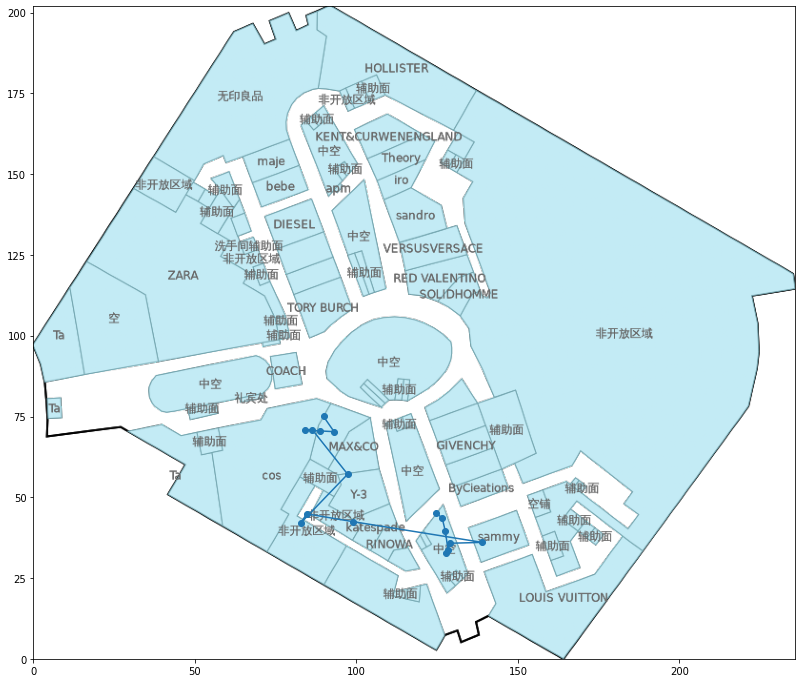

In [56]:
visualize_path(paths[1])